Epoch 1/10
28257/28257 [==============================] - 83s 3ms/step - loss: 0.2287 - accuracy: 0.9291 - val_loss: 0.1408 - val_accuracy: 0.9576
Epoch 2/10
28257/28257 [==============================] - 86s 3ms/step - loss: 0.1391 - accuracy: 0.9570 - val_loss: 0.1108 - val_accuracy: 0.9657
Epoch 3/10
28257/28257 [==============================] - 83s 3ms/step - loss: 0.1164 - accuracy: 0.9629 - val_loss: 0.0966 - val_accuracy: 0.9697
Epoch 4/10
28257/28257 [==============================] - 84s 3ms/step - loss: 0.1028 - accuracy: 0.9668 - val_loss: 0.0954 - val_accuracy: 0.9700
Epoch 5/10
28257/28257 [==============================] - 83s 3ms/step - loss: 0.0933 - accuracy: 0.9694 - val_loss: 0.0850 - val_accuracy: 0.9730
Epoch 6/10
28257/28257 [==============================] - 83s 3ms/step - loss: 0.0864 - accuracy: 0.9714 - val_loss: 0.0816 - val_accuracy: 0.9739
Epoch 7/10
28257/28257 [==============================] - 84s 3ms/step - loss: 0.0807 - accuracy: 0.9730 - val_loss: 0

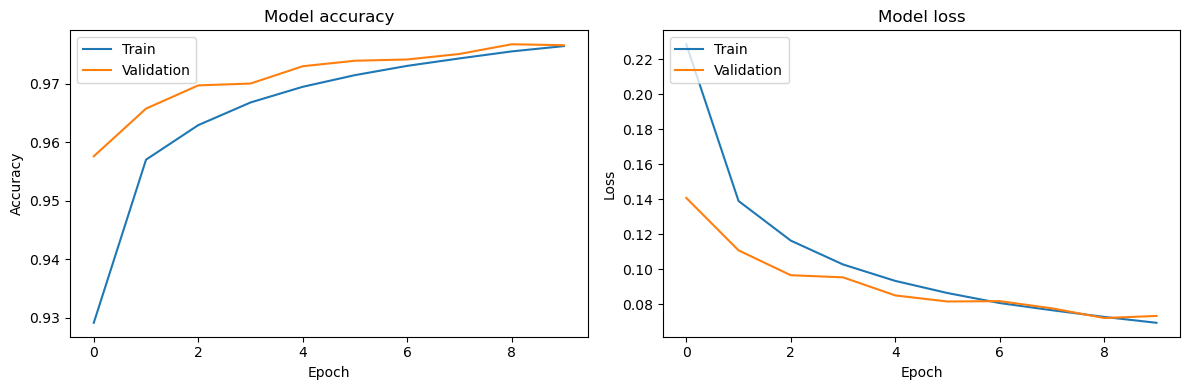

8831/8831 [==============================] - 6s 675us/step
Accuracy: 0.9766530768250733
Confusion Matrix: 
[[24904   649   586    81    81    88]
 [  497 30131   539    39    84    90]
 [  229   432 68089    35    94    15]
 [  124    81    73 26382    25    29]
 [   76    76    50    44 59638  1513]
 [   53    52    20    15   827 66823]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     26389
           1       0.96      0.96      0.96     31380
           2       0.98      0.99      0.99     68894
           3       0.99      0.99      0.99     26714
           4       0.98      0.97      0.98     61397
           5       0.97      0.99      0.98     67790

    accuracy                           0.98    282564
   macro avg       0.98      0.97      0.97    282564
weighted avg       0.98      0.98      0.98    282564



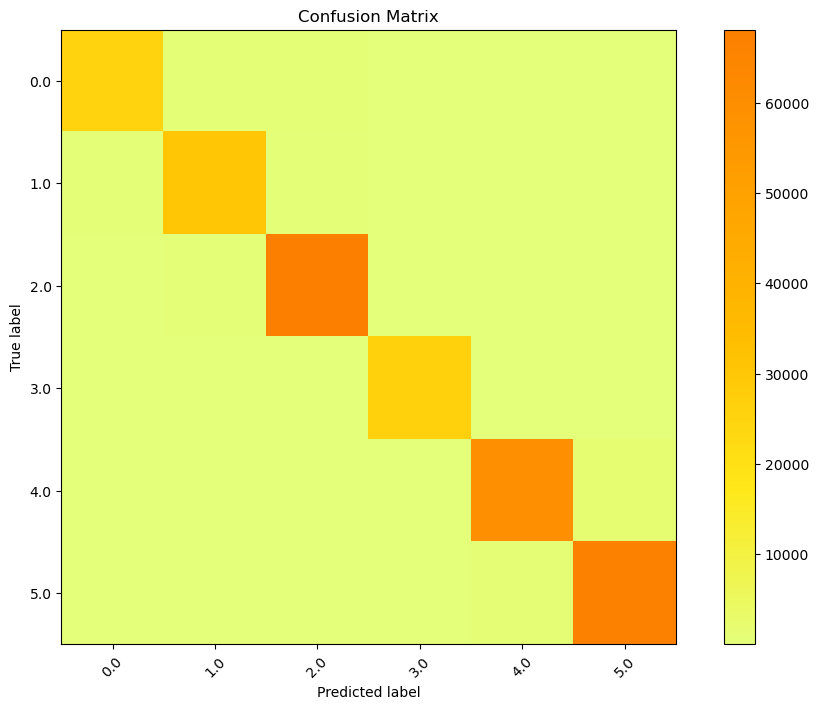

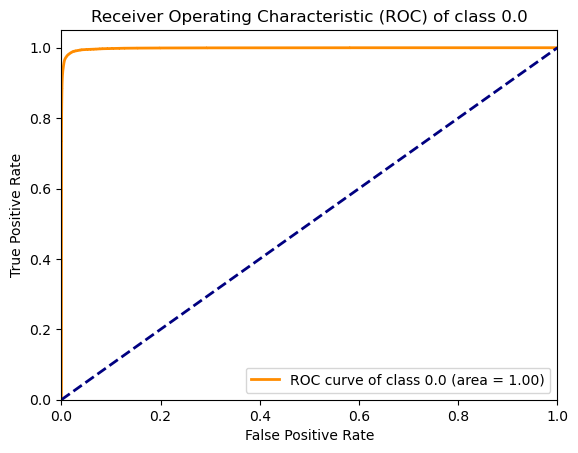

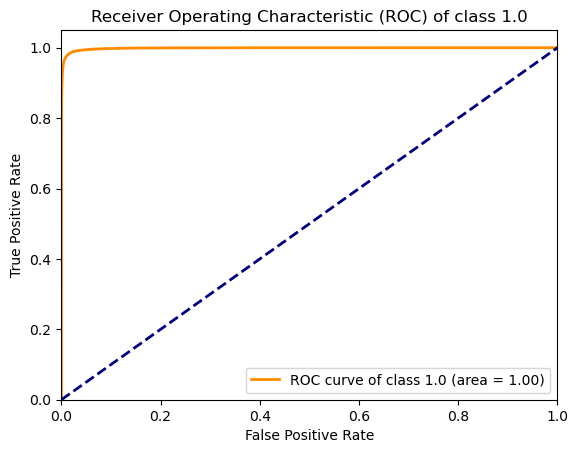

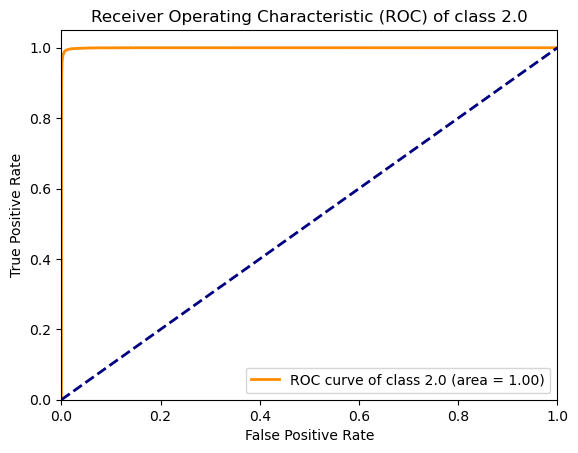

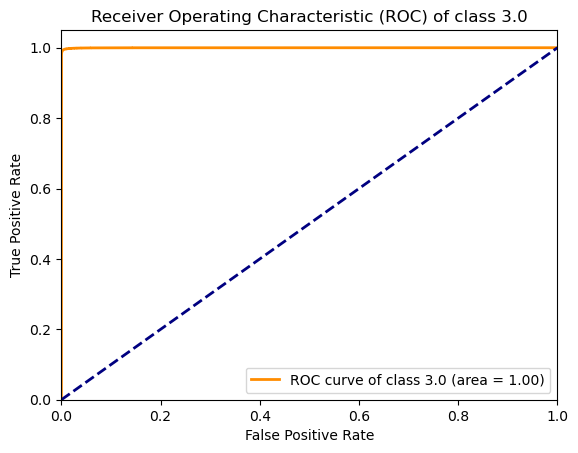

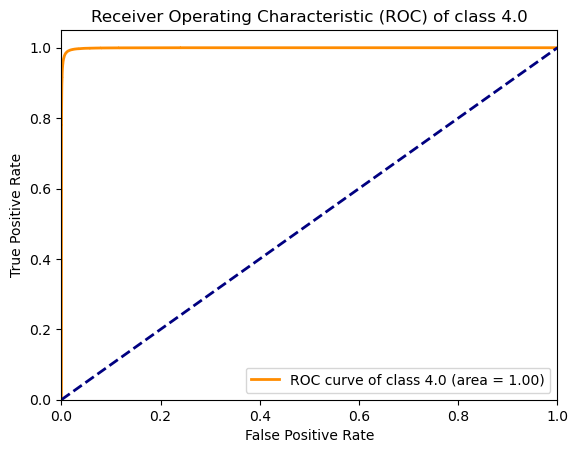

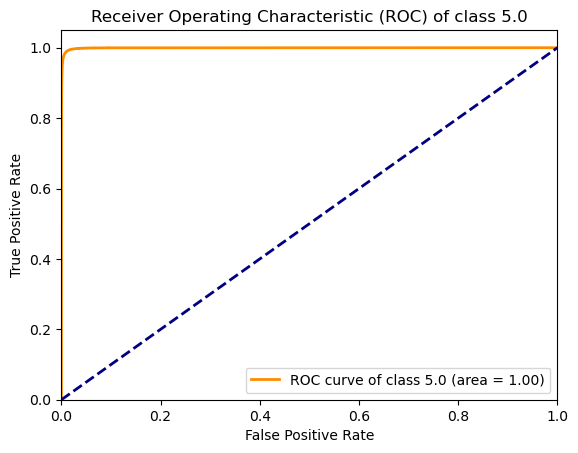

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    """
    Create windows from a data matrix.
    data: The input data. The last column is assumed to be the label if with_label is True.
    window_size: The size of the sliding window.
    step_size: The step size of the sliding window.
    with_label: Whether the data contains a label column.
    """
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            # Take the mode (most common) label in the window as the label for this window
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):

    # Load Data
    dataset = pd.read_csv(file_path)
    
    # Convert to windows
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]  # Convert labels to integers
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    # Preprocess
    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)  # Add a channel dimension
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Build Model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Evaluate again
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(dataset[target].unique()))
    plt.xticks(tick_marks, dataset[target].unique(), rotation=45)
    plt.yticks(tick_marks, dataset[target].unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        for i, label in enumerate(dataset[target].unique()):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                 preprocess='standard', test_size=0.2, 
                 random_state=42, epochs=10, batch_size=32, 
                 save_model=True)
